## Initial import

In [1]:
import pandas
import time
import numpy as np
from sklearn import linear_model

import matplotlib.pyplot as plt

In [2]:
# import all initial data
ff_all_withID = pandas.read_csv("FFChallenge_v4/background.csv", low_memory=False)
ff_all_withID.cf4fint = ((pandas.to_datetime(ff_all_withID.cf4fint) - pandas.to_datetime('1960-01-01')) / np.timedelta64(1, 'D')).astype(int) # date fix

ff_train_outcomes_withID = pandas.read_csv("FFChallenge_v4/train.csv", low_memory=False)

# array of challenge IDs
train_cID = ff_train_outcomes_withID[:]["challengeID"]
all_cID = ff_all_withID[:]["challengeID"]

# drop non-numeric columns for regression
ff_all_withID = ff_all_withID.select_dtypes(include=['int64','float64'])
ff_train_outcomes_withID = ff_train_outcomes_withID.select_dtypes(include=['int64','float64'])

In [3]:
# select training set

ff_train_withID = ff_all_withID[ff_all_withID.challengeID.isin(train_cID)]

In [4]:
# drop challenge IDs for regression

ff_train = ff_train_withID.drop('challengeID', axis=1)
ff_all = ff_all_withID.drop('challengeID', axis=1)
ff_train_outcomes = ff_train_outcomes_withID.drop('challengeID', axis=1)

## Script to output predictions for upload in specified format

In [5]:
# outputs in format for upload
def predictionCreate(predictID,predictOutcomes,filename):
    
    # joins challenge IDs with predicted values
    def cIDjoin(cIDlist,outcomes):
        joined = np.empty([len(cIDlist),outcomes.shape[1]+1])
        for i in range(0,len(cIDlist)):
            joined[i] = np.append(cIDlist[i],outcomes[i])

        return joined
    
    
    zipin = "output/" + filename
    
    import os
    if not os.path.exists(zipin):
        os.makedirs(zipin)
    
    from shutil import copyfile
    from shutil import make_archive

    nardst = "output/" + filename + "/narrative.txt"
    pydst = "output/" + filename + "/a2.ipynb"
    copyfile("narrative.txt", nardst)
    copyfile("a2.ipynb", pydst)
    
    a = cIDjoin(predictID,predictOutcomes)
    a = a[a[:,0].argsort()]
    
    path = "output/" + filename + "/prediction.csv"
    
    d = pandas.DataFrame(a)
    d.columns = ["challengeID","gpa","grit","materialHardship","eviction","layoff","jobTraining"]
    d['challengeID'] = d['challengeID'].astype(np.int64)
    #print(d)
    
    d.to_csv(path,index=False)
    
    zipdst = "submit/" + filename
    make_archive(zipdst, 'zip', zipin)

## Basic imputation

In [6]:
# basic imputation from given script

def imputBasic(indf):
    
    # replace NA's with mode
    indf = indf.fillna(indf.mode().iloc[0])
    # if still NA, replace with 1
    indf = indf.fillna(value=1)
    # replace negative values with 1
    num = indf._get_numeric_data()
    num[num < 0] = 1
    
    return indf

In [8]:
# using basic imputation --> set b1

start_time = time.time()
ff_train_b1 = imputBasic(ff_train)
ff_train_outcomes_b1 = imputBasic(ff_train_outcomes)
ff_all_b1 = imputBasic(ff_all)
print ('Time to impute:', str(time.time() - start_time))

start_time = time.time()
ff_train_b1_withID = imputBasic(ff_train_withID)
ff_train_outcomes_b1_withID = imputBasic(ff_train_outcomes_withID)
ff_all_b1_withID = imputBasic(ff_all_withID)
print ('Time to impute:', str(time.time() - start_time))

Time to impute: 20.58816123008728
Time to impute: 24.82143545150757


## Regression methods

In [9]:
# fits respective models and creates predictions, outputting to passed filename

def predictor(train,trainY,test,filename,regmodel):
    start_time = time.time()
    
    regmodel.fit(train,trainY)
    pred = regmodel.predict(test)
    
    print ('Time to fit and predict:', str(time.time() - start_time))

    predictionCreate(all_cID,pred,filename)    
    return pred

In [10]:
# calculates statistic of relatedness (MSE) to training data outcomes
# significantly underestimates prediction error since we are double dipping, but nonetheless provides a useful and quick measure of prediction accuracy

def trnStat(cand):
    ce1 = ce2 = ce3 = ce4 = ce5 = ce6 = 0
    c1 = c2 = c3 = c4 = c5 = c6 = 0
    for i in range(0,2121):
        if np.isfinite(ff_train_outcomes['gpa'][i]) and np.isfinite(cand[train_cID[i],0]):
            ce1 += (ff_train_outcomes['gpa'][i] - cand[train_cID[i],0])**2
            c1 += 1
        if np.isfinite(ff_train_outcomes['grit'][i]) and np.isfinite(cand[train_cID[i],1]):
            ce2 += (ff_train_outcomes['grit'][i] - cand[train_cID[i],1])**2
            c2 += 1
        if np.isfinite(ff_train_outcomes['materialHardship'][i]) and np.isfinite(cand[train_cID[i],2]):
            ce3 += (ff_train_outcomes['materialHardship'][i] - cand[train_cID[i],2])**2
            c3 += 1
        if np.isfinite(ff_train_outcomes['eviction'][i]) and np.isfinite(cand[train_cID[i],3]):
            ce4 += (ff_train_outcomes['eviction'][i] - cand[train_cID[i],3])**2
            c4 += 1
        if np.isfinite(ff_train_outcomes['layoff'][i]) and np.isfinite(cand[train_cID[i],4]):
            ce5 += (ff_train_outcomes['layoff'][i] - cand[train_cID[i],4])**2
            c5 += 1
        if np.isfinite(ff_train_outcomes['jobTraining'][i]) and np.isfinite(cand[train_cID[i],5]):
            ce6 += (ff_train_outcomes['jobTraining'][i] - cand[train_cID[i],5])**2
            c6 += 1
            
    return(ce1/c1,ce2/c2,ce3/c3,ce4/c4,ce5/c5,ce6/c6)

### On test data (basic imputation)

In [11]:
lnreg = linear_model.LinearRegression()
b1_lr = predictor(ff_train_b1,ff_train_outcomes_b1,ff_all_b1,"b1_lr",lnreg)
trnStat(b1_lr)

Time to fit and predict: 9.631571054458618


(0.8774021274066961,
 0.68951726341953323,
 0.057094211926586154,
 0.1137240196726374,
 0.38755710650957848,
 0.43338737480763029)

In [12]:
lassoreg = linear_model.Lasso()
b1_lasso = predictor(ff_train_b1,ff_train_outcomes_b1,ff_all_b1,"b1_lasso",lassoreg)
trnStat(b1_lasso)

Time to fit and predict: 30.109335899353027


(0.52881297337868705,
 0.34412053294407602,
 0.028882129038833339,
 0.059752010719279346,
 0.18339435558693085,
 0.2111547900087728)

In [13]:
ridgereg = linear_model.Ridge()
b1_ridge = predictor(ff_train_b1,ff_train_outcomes_b1,ff_all_b1,"b1_ridge",ridgereg)
trnStat(b1_ridge)

Time to fit and predict: 3.8826706409454346


(0.87697648510115433,
 0.68895051185921785,
 0.057052512784486108,
 0.11364836019108834,
 0.38729187635064038,
 0.43320539127926011)

In [14]:
elasticreg = linear_model.ElasticNet()
b1_elastic = predictor(ff_train_b1,ff_train_outcomes_b1,ff_all_b1,"b1_elastic",elasticreg)
trnStat(b1_elastic)

Time to fit and predict: 41.64161133766174


(0.54556206582482591,
 0.35318046609044074,
 0.029592216731218021,
 0.060531602858318663,
 0.18753254079583789,
 0.21575348367581321)

In [15]:
llreg = linear_model.LassoLars()
b1_lassolars = predictor(ff_train_b1,ff_train_outcomes_b1,ff_all_b1,"b1_lassolars",llreg)
trnStat(b1_lassolars)

Time to fit and predict: 25.982985734939575


(0.47211531571137277,
 0.27118641556556289,
 0.025263624040620679,
 0.056420548258489016,
 0.17228996109056585,
 0.1849903859192743)

In [17]:
mtlreg = linear_model.MultiTaskLasso()
b1_mtlasso = predictor(ff_train_b1,ff_train_outcomes_b1,ff_all_b1,"b1_mtlasso",mtlreg)
trnStat(b1_mtlasso)

Time to fit and predict: 187.62580561637878


(0.5368509888005093,
 0.34761956857480913,
 0.030033487208562734,
 0.061127119547649433,
 0.18735934820552436,
 0.21529907380856594)

## Binary predictors

In [21]:
def LogisticMultiPredictor(train,trainY,test):

    reg4 = linear_model.LogisticRegression()
    reg5 = linear_model.LogisticRegression()
    reg6 = linear_model.LogisticRegression()

    start_time = time.time()
    reg4.fit(train,trainY['eviction'])
    print ('Time to fit eviction:', str(time.time() - start_time))
    
    start_time = time.time()
    reg5.fit(train,trainY['layoff'])
    print ('Time to fit layoff:', str(time.time() - start_time))

    start_time = time.time()
    reg6.fit(train,trainY['jobTraining'])
    print ('Time to fit job training:', str(time.time() - start_time))

    pred4 = reg4.predict(test)
    pred5 = reg5.predict(test)
    pred6 = reg6.predict(test)

    return (pred4,pred5,pred6)

In [22]:
def MNBMultiPredictor(train,trainY,test):
    from sklearn.naive_bayes import MultinomialNB
    reg4 = MultinomialNB()
    reg5 = MultinomialNB()
    reg6 = MultinomialNB()
    
    reg4.fit(train,trainY['eviction'])
    reg5.fit(train,trainY['layoff'])
    reg6.fit(train,trainY['jobTraining'])
    
    pred4 = reg4.predict(test)
    pred5 = reg5.predict(test)
    pred6 = reg6.predict(test)

    return (pred4,pred5,pred6)

In [23]:
b1_log_ff_evic, b1_log_ff_layoff, b1_log_ff_jobtrn = LogisticMultiPredictor(ff_train_b1,ff_train_outcomes_b1,ff_all_b1)

Time to fit eviction: 155.95341277122498
Time to fit eviction: 507.4076397418976
Time to fit eviction: 698.8400011062622


In [24]:
b1_mnb_ff_evic, b1_mnb_ff_layoff, b1_mnb_ff_jobtrn = MNBMultiPredictor(ff_train_b1,ff_train_outcomes_b1,ff_all_b1)

In [25]:
# combines binary predictions with some other model for continuous variables
def binaryComb(evic,layoff,jobtrn,train,trainY,test,filename,regmodel):
    regmodel.fit(train,trainY[['gpa','grit','materialHardship']])
    pred = regmodel.predict(test)
    
    evic = np.reshape(evic,(len(evic),1))
    layoff = np.reshape(layoff,(len(layoff),1))
    jobtrn = np.reshape(jobtrn,(len(jobtrn),1))
    
    pred = np.hstack((pred,evic,layoff,jobtrn))
    predictionCreate(all_cID,pred,filename)
    
    return pred

In [30]:
llreg = linear_model.LassoLars()
b1_log_lassolars = binaryComb(b1_log_ff_evic,b1_log_ff_layoff,b1_log_ff_jobtrn,ff_train_b1,ff_train_outcomes_b1,ff_all_b1,"b1_log_lassolars",llreg)
trnStat(b1_log_lassolars)

(0.47211531571137277,
 0.27118641556556289,
 0.025263624040620679,
 0.093214530500342702,
 0.26546593578700078,
 0.30869267624914443)

In [31]:
llreg = linear_model.LassoLars()
b1_mnb_lassolars = binaryComb(b1_mnb_ff_evic,b1_mnb_ff_layoff,b1_mnb_ff_jobtrn,ff_train_b1,ff_train_outcomes_b1,ff_all_b1,"b1_mnb_lassolars",llreg)
trnStat(b1_mnb_lassolars)

(0.47211531571137277,
 0.27118641556556289,
 0.025263624040620679,
 0.71350239890335843,
 0.610806577916993,
 0.44421629021218345)

## Cross-validation for hyperparameter tuning

In [54]:
# manual cross-validation to determine optimal alpha for LASSO

from sklearn.model_selection import KFold

def cvLasso(alphaList, folds, cidX, cidY):
    
    def trnStatMod(cand,actual):
        ce1 = ce2 = ce3 = ce4 = ce5 = ce6 = 0
        c1 = c2 = c3 = c4 = c5 = c6 = 0

        for i in range(0,len(cand)):
            if np.isfinite(actual[i,1]) and np.isfinite(cand[i,0]):
                ce1 += (actual[i,1] - cand[i,0])**2
                c1 += 1
            if np.isfinite(actual[i,2]) and np.isfinite(cand[i,1]):
                ce2 += (actual[i,2] - cand[i,1])**2
                c2 += 1
            if np.isfinite(actual[i,3]) and np.isfinite(cand[i,2]):
                ce3 += (actual[i,3] - cand[i,2])**2
                c3 += 1
            if np.isfinite(actual[i,4]) and np.isfinite(cand[i,3]):
                ce4 += (actual[i,4] - cand[i,3])**2
                c4 += 1
            if np.isfinite(actual[i,5]) and np.isfinite(cand[i,4]):
                ce5 += (actual[i,5] - cand[i,4])**2
                c5 += 1
            if np.isfinite(actual[i,6]) and np.isfinite(cand[i,5]):
                ce6 += (actual[i,6] - cand[i,5])**2
                c6 += 1

        return(ce1/c1,ce2/c2,ce3/c3,ce4/c4,ce5/c5,ce6/c6)
    
    
    scores = []
    kf = KFold(n_splits=folds)
    
    for i in alphaList:
        scores.append([])
        
    numAlphas = len(alphaList)
    
    count = 1
                    
    for train_index, test_index in kf.split(ff_train_b1_withID):
        #print(train_index)
        train_cID, test_cID = [cidX['challengeID'].iloc[k] for k in train_index], [cidX['challengeID'].iloc[k] for k in test_index]
        
        trainX, testX = cidX.loc[cidX['challengeID'].isin(train_cID)], cidX.loc[cidX['challengeID'].isin(test_cID)] 
        trainX_cls, testX_cls = cidY.loc[cidY['challengeID'].isin(train_cID)], cidY.loc[cidY['challengeID'].isin(test_cID)]

        trainX_c = trainX.drop(['challengeID'],axis=1)
        testX_c = testX.drop(['challengeID'],axis=1)
        trainX_cls_c = trainX_cls.drop(['challengeID'],axis=1)
        testX_cls_npa = testX_cls.values
                
        for i in range(0,numAlphas):
            print(".. ",end='')
            iscores = scores[i]
            
            LassoReg = linear_model.Lasso(alpha = alphaList[i])
            LassoReg.fit(trainX_c,trainX_cls_c)
            pred = LassoReg.predict(testX_c)
            
            mse = trnStatMod(pred,testX_cls_npa)
            iscores.append(mse) 
        count += 1
        print()
    
    print()
    print()
    for i in range(0,numAlphas):
        print("For ALPHA = " + str(alphaList[i]) + ", average MSEs are:")
        print(np.mean(scores[i], axis=0))
        print()

In [60]:
# manual cross-validation to determine alpha for ridge regression

from sklearn.model_selection import KFold

def cvRidge(alphaList, folds, cidX, cidY):
    
    def trnStatMod(cand,actual):
        ce1 = ce2 = ce3 = ce4 = ce5 = ce6 = 0
        c1 = c2 = c3 = c4 = c5 = c6 = 0

        for i in range(0,len(cand)):
            if np.isfinite(actual[i,1]) and np.isfinite(cand[i,0]):
                ce1 += (actual[i,1] - cand[i,0])**2
                c1 += 1
            if np.isfinite(actual[i,2]) and np.isfinite(cand[i,1]):
                ce2 += (actual[i,2] - cand[i,1])**2
                c2 += 1
            if np.isfinite(actual[i,3]) and np.isfinite(cand[i,2]):
                ce3 += (actual[i,3] - cand[i,2])**2
                c3 += 1
            if np.isfinite(actual[i,4]) and np.isfinite(cand[i,3]):
                ce4 += (actual[i,4] - cand[i,3])**2
                c4 += 1
            if np.isfinite(actual[i,5]) and np.isfinite(cand[i,4]):
                ce5 += (actual[i,5] - cand[i,4])**2
                c5 += 1
            if np.isfinite(actual[i,6]) and np.isfinite(cand[i,5]):
                ce6 += (actual[i,6] - cand[i,5])**2
                c6 += 1

        return(ce1/c1,ce2/c2,ce3/c3,ce4/c4,ce5/c5,ce6/c6)
    
    
    scores = []
    kf = KFold(n_splits=folds)
    
    for i in alphaList:
        scores.append([])
        
    numAlphas = len(alphaList)
    
    count = 1
                    
    for train_index, test_index in kf.split(ff_train_b1_withID):
        #print(train_index)
        train_cID, test_cID = [cidX['challengeID'].iloc[k] for k in train_index], [cidX['challengeID'].iloc[k] for k in test_index]
        
        trainX, testX = cidX.loc[cidX['challengeID'].isin(train_cID)], cidX.loc[cidX['challengeID'].isin(test_cID)] 
        trainX_cls, testX_cls = cidY.loc[cidY['challengeID'].isin(train_cID)], cidY.loc[cidY['challengeID'].isin(test_cID)]

        trainX_c = trainX.drop(['challengeID'],axis=1)
        testX_c = testX.drop(['challengeID'],axis=1)
        trainX_cls_c = trainX_cls.drop(['challengeID'],axis=1)
        testX_cls_npa = testX_cls.values
                
        for i in range(0,numAlphas):
            print(".. ",end='')
            iscores = scores[i]
            
            RidgeReg = linear_model.Ridge(alpha = alphaList[i])
            RidgeReg.fit(trainX_c,trainX_cls_c)
            pred = RidgeReg.predict(testX_c)
            
            mse = trnStatMod(pred,testX_cls_npa)
            iscores.append(mse) 
        count += 1
        print()
        
    for i in range(0,numAlphas):
        print("For ALPHA = " + str(alphaList[i]) + ", average MSEs are:")
        print(np.mean(scores[i], axis=0))
        print()

In [61]:
# manual cross-validation to determine alpha for ridge regression

from sklearn.model_selection import KFold

def cvLassoLars(alphaList, folds, cidX, cidY):
    
    def trnStatMod(cand,actual):
        ce1 = ce2 = ce3 = ce4 = ce5 = ce6 = 0
        c1 = c2 = c3 = c4 = c5 = c6 = 0

        for i in range(0,len(cand)):
            if np.isfinite(actual[i,1]) and np.isfinite(cand[i,0]):
                ce1 += (actual[i,1] - cand[i,0])**2
                c1 += 1
            if np.isfinite(actual[i,2]) and np.isfinite(cand[i,1]):
                ce2 += (actual[i,2] - cand[i,1])**2
                c2 += 1
            if np.isfinite(actual[i,3]) and np.isfinite(cand[i,2]):
                ce3 += (actual[i,3] - cand[i,2])**2
                c3 += 1
            if np.isfinite(actual[i,4]) and np.isfinite(cand[i,3]):
                ce4 += (actual[i,4] - cand[i,3])**2
                c4 += 1
            if np.isfinite(actual[i,5]) and np.isfinite(cand[i,4]):
                ce5 += (actual[i,5] - cand[i,4])**2
                c5 += 1
            if np.isfinite(actual[i,6]) and np.isfinite(cand[i,5]):
                ce6 += (actual[i,6] - cand[i,5])**2
                c6 += 1

        return(ce1/c1,ce2/c2,ce3/c3,ce4/c4,ce5/c5,ce6/c6)
    
    
    scores = []
    kf = KFold(n_splits=folds)
    
    for i in alphaList:
        scores.append([])
        
    numAlphas = len(alphaList)
    
    count = 1
                    
    for train_index, test_index in kf.split(ff_train_b1_withID):
        #print(train_index)
        train_cID, test_cID = [cidX['challengeID'].iloc[k] for k in train_index], [cidX['challengeID'].iloc[k] for k in test_index]
        
        trainX, testX = cidX.loc[cidX['challengeID'].isin(train_cID)], cidX.loc[cidX['challengeID'].isin(test_cID)] 
        trainX_cls, testX_cls = cidY.loc[cidY['challengeID'].isin(train_cID)], cidY.loc[cidY['challengeID'].isin(test_cID)]

        trainX_c = trainX.drop(['challengeID'],axis=1)
        testX_c = testX.drop(['challengeID'],axis=1)
        trainX_cls_c = trainX_cls.drop(['challengeID'],axis=1)
        testX_cls_npa = testX_cls.values
                
        for i in range(0,numAlphas):
            print(".. ",end='')
            iscores = scores[i]
            
            LLReg = linear_model.LassoLars(alpha = alphaList[i])
            LLReg.fit(trainX_c,trainX_cls_c)
            pred = LLReg.predict(testX_c)
            
            mse = trnStatMod(pred,testX_cls_npa)
            iscores.append(mse)  
        count += 1
        print()
        
    for i in range(0,numAlphas):
        print("For ALPHA = " + str(alphaList[i]) + ", average MSEs are:")
        print(np.mean(scores[i], axis=0))
        print()

In [58]:
cvLasso((.001,.01,1,10,100,200,500,1000),5,ff_train_b1_withID,ff_train_outcomes_b1_withID)

.. 

C:\Users\Adam Chang\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


.. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. 


For ALPHA = 0.001, average MSEs are:
[ 0.99576935  0.66490027  0.05660044  0.14347446  0.47905825  0.55095582]

For ALPHA = 0.01, average MSEs are:
[ 0.69039185  0.47578267  0.02959432  0.08913175  0.29354477  0.3378657 ]

For ALPHA = 1, average MSEs are:
[ 0.30879109  0.21918856  0.0183247   0.04325087  0.12483961  0.14884406]

For ALPHA = 10, average MSEs are:
[ 0.27650701  0.20683386  0.01798693  0.04049841  0.11350971  0.13188756]

For ALPHA = 100, average MSEs are:
[ 0.2718495   0.21117187  0.01849445  0.0394645   0.11001015  0.12741623]

For ALPHA = 200, average MSEs are:
[ 0.27018937  0.21106409  0.0186176   0.03943637  0.10943875  0.12717117]

For ALPHA = 500, average MSEs are:
[ 0.27107845  0.21118774  0.01878622  0.03944958  0.10994943  0.12764227]

For ALPHA = 1000, average MSEs are:
[ 0.271966    0.21173833  0.01891251  0.03951005  0.11015343  0.129221

In [67]:
cvLasso((2000,5000,10000),5,ff_train_b1_withID,ff_train_outcomes_b1_withID)

.. .. .. 
.. .. .. 
.. .. .. 
.. .. .. 
.. .. .. 


For ALPHA = 2000, average MSEs are:
[ 0.27287903  0.2142684   0.01896964  0.03951005  0.11026244  0.1323218 ]

For ALPHA = 5000, average MSEs are:
[ 0.27583413  0.22990754  0.01896964  0.03951005  0.1102653   0.13564245]

For ALPHA = 10000, average MSEs are:
[ 0.27944247  0.22990754  0.01896964  0.03951005  0.1102653   0.13564245]



In [64]:
cvRidge((1,5,10,25,50,100,200,500,1000,2000,5000,10000),5,ff_train_b1_withID,ff_train_outcomes_b1_withID)

.. .. .. .. .. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. .. .. .. .. 
For ALPHA = 1, average MSEs are:
[ 1.08385899  0.74381373  0.06695997  0.15878905  0.53462015  0.60424656]

For ALPHA = 5, average MSEs are:
[ 1.08084505  0.741573    0.06680733  0.1584398   0.53335163  0.60294989]

For ALPHA = 10, average MSEs are:
[ 1.07721692  0.73892561  0.06662294  0.15802573  0.53184736  0.60138859]

For ALPHA = 25, average MSEs are:
[ 1.06707477  0.7317485   0.06610323  0.15689475  0.52771827  0.59700608]

For ALPHA = 50, average MSEs are:
[ 1.0520047   0.72149583  0.06531606  0.15525121  0.52162968  0.59039537]

For ALPHA = 100, average MSEs are:
[ 1.02649747  0.70477603  0.06393517  0.15247831  0.51110393  0.57881471]

For ALPHA = 200, average MSEs are:
[ 0.98681013  0.67959031  0.06166963  0.14806768  0.49380622  0.5596949 ]

For ALPHA = 500, average MSEs are:
[ 0.91016755  0.6

In [70]:
cvRidge((100000,1000000,10000000,100000000,1000000000000,1000000000000000,1000000000000000000),5,ff_train_b1_withID,ff_train_outcomes_b1_withID)

.. .. .. .. .. .. .. 
.. .. .. .. .. .. .. 
.. .. .. .. .. .. .. 
.. .. .. .. .. .. .. 
.. .. .. .. .. .. .. 
For ALPHA = 100000, average MSEs are:
[ 0.44917343  0.33819284  0.02795725  0.07703831  0.21839092  0.24846183]

For ALPHA = 1000000, average MSEs are:
[ 0.3619909   0.26883214  0.02317529  0.05970355  0.16571963  0.19803979]

For ALPHA = 10000000, average MSEs are:
[ 0.32125264  0.23384711  0.02098912  0.04947136  0.13729774  0.16546341]

For ALPHA = 100000000, average MSEs are:
[ 0.29586286  0.21685893  0.01913607  0.04454224  0.12356836  0.14730351]

For ALPHA = 1000000000000, average MSEs are:
[ 0.26974934  0.2117623   0.01845565  0.03945761  0.11002675  0.12757417]

For ALPHA = 1000000000000000, average MSEs are:
[ 0.27837709  0.22907446  0.01893177  0.0395007   0.11023669  0.13543254]

For ALPHA = 1000000000000000000, average MSEs are:
[ 0.2794413   0.22990664  0.0189696   0.03951004  0.11026527  0.13564223]



In [72]:
cvLassoLars((1,100,500,1000,5000,10000,1000000,1000000000),5,ff_train_b1_withID,ff_train_outcomes_b1_withID)

.. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. 
.. .. .. .. .. .. .. .. 
For ALPHA = 1, average MSEs are:
[ 0.27944247  0.22990754  0.01896964  0.03951005  0.1102653   0.13564245]

For ALPHA = 100, average MSEs are:
[ 0.27944247  0.22990754  0.01896964  0.03951005  0.1102653   0.13564245]

For ALPHA = 500, average MSEs are:
[ 0.27944247  0.22990754  0.01896964  0.03951005  0.1102653   0.13564245]

For ALPHA = 1000, average MSEs are:
[ 0.27944247  0.22990754  0.01896964  0.03951005  0.1102653   0.13564245]

For ALPHA = 5000, average MSEs are:
[ 0.27944247  0.22990754  0.01896964  0.03951005  0.1102653   0.13564245]

For ALPHA = 10000, average MSEs are:
[ 0.27944247  0.22990754  0.01896964  0.03951005  0.1102653   0.13564245]

For ALPHA = 1000000, average MSEs are:
[ 0.27944247  0.22990754  0.01896964  0.03951005  0.1102653   0.13564245]

For ALPHA = 1000000000, average MSEs are:
[ 0.27944247  0.22990754  0.01896964  0.03951005  0.11026

In [71]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

## Most significant features

In [73]:
ffLabels = pandas.read_csv("FFChallenge_v4/FFMetadata20180221.csv", low_memory=False, usecols=["new_name", "varlab"])

In [74]:
def coefSelector(coefs,n,alltestdf):
    coefs0_ind = np.argpartition(coefs[0], -n)[-n:]
    coefs1_ind = np.argpartition(coefs[1], -n)[-n:]
    coefs2_ind = np.argpartition(coefs[2], -n)[-n:]
    coefs3_ind = np.argpartition(coefs[3], -n)[-n:]
    coefs4_ind = np.argpartition(coefs[4], -n)[-n:]
    coefs5_ind = np.argpartition(coefs[5], -n)[-n:]

    vals0 = alltestdf.columns.values[coefs0_ind]
    vals1 = alltestdf.columns.values[coefs1_ind]
    vals2 = alltestdf.columns.values[coefs2_ind]
    vals3 = alltestdf.columns.values[coefs3_ind]
    vals4 = alltestdf.columns.values[coefs4_ind]
    vals5 = alltestdf.columns.values[coefs5_ind]
    
    labs0 = []
    labs1 = []
    labs2 = []
    labs3 = []
    labs4 = []
    labs5 = []
    
    for x in vals0:
        labs0.append(ffLabels.varlab[ffLabels.new_name[ffLabels.new_name == x].index.tolist()].iloc[0])
        
    for x in vals1:
        labs1.append(ffLabels.varlab[ffLabels.new_name[ffLabels.new_name == x].index.tolist()].iloc[0])
        
    for x in vals2:
        labs2.append(ffLabels.varlab[ffLabels.new_name[ffLabels.new_name == x].index.tolist()].iloc[0])
        
    for x in vals3:
        labs3.append(ffLabels.varlab[ffLabels.new_name[ffLabels.new_name == x].index.tolist()].iloc[0])
        
    for x in vals4:
        labs4.append(ffLabels.varlab[ffLabels.new_name[ffLabels.new_name == x].index.tolist()].iloc[0])
        
    for x in vals5:
        labs5.append(ffLabels.varlab[ffLabels.new_name[ffLabels.new_name == x].index.tolist()].iloc[0])
        
    print("GPA most significant features in this regression: " + str(labs0))
    print("Coefficients: " + str(np.partition(coefs[0], -n)[-n:]))
    
    print()
    print("========================================================================")
    print()
    
    print("Grit most significant features in this regression: " + str(labs1))
    print("Coefficients: " + str(np.partition(coefs[1], -n)[-n:]))

    print()
    print("========================================================================")
    print()
    
    print("Material hardship most significant features in this regression: " + str(labs2))
    print("Coefficients: " + str(np.partition(coefs[2], -n)[-n:]))
    
    print()
    print("========================================================================")
    print()
    
    print("Eviction most significant features in this regression: " + str(labs3))
    print("Coefficients: " + str(np.partition(coefs[3], -n)[-n:]))
    
    print()
    print("========================================================================")
    print()

    print("Layoff most significant features in this regression: " + str(labs4))
    print("Coefficients: " + str(np.partition(coefs[4], -n)[-n:]))
    
    print()
    print("========================================================================")
    print()
    
    print("Job Training most significant features in this regression: " + str(labs5))
    print("Coefficients: " + str(np.partition(coefs[5], -n)[-n:]))
    
    

In [105]:
# linear regression features
linregbasic = linear_model.LinearRegression()
linregbasic.fit(ff_train_b1,ff_train_outcomes_b1)
lrcoefs = linregbasic.coef_

coefSelector(lrcoefs,10,ff_all_b1)

GPA most significant features in this regression: ['b9 during last two mths total days you were not able to care for child/children', 'How much time did you serve, altogether? (months)', 'Agree/disagree: my religious faith is a guide for the way I treat my family?', 'G23k. Past year, times SCG slapped child on the hand, arm, or leg', 'J2F. Number of servings of fresh fruit or vegetables child has on typical day', 'K2b. This is a close-knit neighborhood', 'a18a_7 if child disagrees with you says negative things about you, what do you d', 'On a scale of 1-(least like) to 5-(most like) - Child is very sociable', 'distance to c - resistant', 'L5. Number of days per week you drop off or pick up child']
Coefficients: [ 0.01735906  0.01740225  0.01829731  0.02279418  0.02307888  0.01950042
  0.01897293  0.01956886  0.02126713  0.01878621]


Grit most significant features in this regression: ['How many years did you attend this program?', 'How life diff if married BF, overall happiness?', 'Agr

In [106]:
# lasso features
lassoregbasic = linear_model.Lasso()
lassoregbasic.fit(ff_train_b1,ff_train_outcomes_b1)
lassocoefs = lassoregbasic.coef_

coefSelector(lassocoefs,10,ff_all_b1)

GPA most significant features in this regression: ['When did you and mother get separated/divorced? (year)', 'When did you and CP get married? (year)', 'When did you and mother separate? (Year)', 'F3B. Monthly mortgage payments including taxes/insurance that are included', 'Constructed - Total monthly expense for food used at home', 'Father three-year city replicate weight no. 7', 'Mother one-year city replicate weight no. 5', 'How much money does [gov agency] give you? ($)', 'How much do you pay out-of-pocket for all child care you currently use?', 'Mother one-year city replicate weight no. 9']
Coefficients: [  9.13998946e-05   1.02939367e-04   1.03327115e-04   2.81293412e-04
   1.06134552e-04   1.06638348e-04   1.08428863e-04   1.08373417e-04
   1.20110593e-04   1.11909855e-04]


Grit most significant features in this regression: ['What are your mo expenses for rent or mortgage?', 'Mother three-year city replicate weight no. 10', 'When did you last receive welfare or TANF? (year)', '

In [107]:
# lassolars features
lassolarsregbasic = linear_model.Lasso()
lassolarsregbasic.fit(ff_train_b1,ff_train_outcomes_b1)
lassolarscoefs = lassolarsregbasic.coef_

coefSelector(lassolarscoefs,10,ff_all_b1)

GPA most significant features in this regression: ['When did you and mother get separated/divorced? (year)', 'When did you and CP get married? (year)', 'When did you and mother separate? (Year)', 'F3B. Monthly mortgage payments including taxes/insurance that are included', 'Constructed - Total monthly expense for food used at home', 'Father three-year city replicate weight no. 7', 'Mother one-year city replicate weight no. 5', 'How much money does [gov agency] give you? ($)', 'How much do you pay out-of-pocket for all child care you currently use?', 'Mother one-year city replicate weight no. 9']
Coefficients: [  9.13998946e-05   1.02939367e-04   1.03327115e-04   2.81293412e-04
   1.06134552e-04   1.06638348e-04   1.08428863e-04   1.08373417e-04
   1.20110593e-04   1.11909855e-04]


Grit most significant features in this regression: ['What are your mo expenses for rent or mortgage?', 'Mother three-year city replicate weight no. 10', 'When did you last receive welfare or TANF? (year)', '

In [108]:
# ridge features
ridgeregbasic = linear_model.Ridge()
ridgeregbasic.fit(ff_train_b1,ff_train_outcomes_b1)
ridgecoefs = ridgeregbasic.coef_

coefSelector(ridgecoefs,10,ff_all_b1)

GPA most significant features in this regression: ['b9 during last two mths total days you were not able to care for child/children', 'How much time did you serve, altogether? (months)', 'Agree/disagree: my religious faith is a guide for the way I treat my family?', 'On a scale of 1-(least like) to 5-(most like) - Child is very sociable', 'J2F. Number of servings of fresh fruit or vegetables child has on typical day', 'G23k. Past year, times SCG slapped child on the hand, arm, or leg', 'L5. Number of days per week you drop off or pick up child', 'K2b. This is a close-knit neighborhood', 'distance to c - resistant', 'a18a_7 if child disagrees with you says negative things about you, what do you d']
Coefficients: [ 0.01733263  0.01737717  0.01827158  0.0195262   0.02301824  0.02275964
  0.01877179  0.01946171  0.02125828  0.01894816]


Grit most significant features in this regression: ['How many years did you attend this program?', 'F1C. Routine administrative duties and paperwork inter

In [109]:
# elastic features
elasticregbasic = linear_model.ElasticNet()
elasticregbasic.fit(ff_train_b1,ff_train_outcomes_b1)
elasticcoefs = elasticregbasic.coef_

coefSelector(elasticcoefs,10,ff_all_b1)

GPA most significant features in this regression: ['Mother baseline city replicate weight no. 1', 'How much does mother weigh? (pounds)', 'How much money does [gov agency] give you? ($)', 'How much do you pay out-of-pocket for all child care you currently use?', 'How much money does [other] give you? ($)', 'Constructed - PCG PPVT - Raw score', 'What type of business do you own?', 'In what country/territory was your father born?', 'F3B. Monthly mortgage payments including taxes/insurance that are included', 'Father three-year city replicate weight no. 7']
Coefficients: [ 0.00017668  0.00018379  0.00020896  0.00021136  0.00022601  0.00026274
  0.00032873  0.00052593  0.0003473   0.00028872]


Grit most significant features in this regression: ['How much money does government agency give you? ($)', 'How much has he agreed to give you each month?-($ Amount)', 'How much do you pay each month? ($)', 'What was the date of your 2nd marriage, other than mother? (year)', 'B30D2. Year father went

## Better imputation

In [81]:
from sklearn.preprocessing import Imputer

# imputation using sklearn imputer on mean
def imputSklMean(indf):
    indf = indf.values
    skimput = Imputer(strategy='mean')
    indfn = skimput.fit_transform(indf)
    indfn = pandas.DataFrame(indfn)
    
    return indfn

# imputation using sklearn imputer on median
def imputSklMedian(indf):

    indf = indf.values
    skimput = Imputer(strategy='median')
    indfn = skimput.fit_transform(indf)
    indfn = pandas.DataFrame(indfn)
    
    return indfn

# impute with bfill first, then ffill
def imputBF(indf):
    
    # replace NA's with mode
    indf = indf.fillna(method='bfill')
    indf = indf.fillna(method='ffill')
    # if still NA, replace with 1
    indf = indf.fillna(value=1)
    # replace negative values with 1
    num = indf._get_numeric_data()
    num[num < 0] = 1
    
    return indf

# impute with ffill first, then bfill
def imputFB(indf):
    
    # replace NA's with mode
    indf = indf.fillna(method='ffill')
    indf = indf.fillna(method='bfill')
    # if still NA, replace with 1
    indf = indf.fillna(value=1)
    # replace negative values with 1
    num = indf._get_numeric_data()
    num[num < 0] = 1
    
    return indf

# impute using mean of bfill and ffill
def imputBFM(indf):
    indf1 = indf.fillna(method='ffill')
    indf1 = indf1.fillna(value=1)
    indf1 = indf1.values
    
    indf2 = indf.fillna(method='bfill')
    indf2 = indf2.fillna(value=1)
    indf2 = indf2.values
    
    indf_avg = np.add(indf1, indf2) / 2
    indfavg = pandas.DataFrame(indf_avg) 
        
    return indfavg

In [82]:
# mean imputation using sklearn imputer (set sklmean)

start_time = time.time()

ff_train_sklmean = imputSklMean(ff_train)
ff_train_outcomes_sklmean = imputSklMean(ff_train_outcomes)
ff_all_sklmean = imputSklMean(ff_all)

print ('Time to impute:', str(time.time() - start_time))

llreg = linear_model.LassoLars()
sklmean_lassolars = predictor(ff_train_sklmean,ff_train_outcomes_sklmean,ff_all_sklmean,"sklmean_lassolars",llreg)
trnStat(sklmean_lassolars)

Time to impute: 4.27112340927124
Time to fit and predict: 16.510746717453003


(0.44227348081563311,
 0.23518484511052101,
 0.024215127110043866,
 0.056074160477778051,
 0.16536775883669178,
 0.17965342107199206)

In [84]:
# median imputation using sklearn imputer (set sklmed)

start_time = time.time()

ff_train_sklmed = imputSklMedian(ff_train)
ff_train_outcomes_sklmed = imputSklMedian(ff_train_outcomes)
ff_all_sklmed = imputSklMedian(ff_all)

print ('Time to impute:', str(time.time() - start_time))

llreg = linear_model.LassoLars()
sklmed_lassolars = predictor(ff_train_sklmed,ff_train_outcomes_sklmed,ff_all_sklmed,"sklmed_lassolars",llreg)
trnStat(sklmed_lassolars)

Time to impute: 16.528984785079956
Time to fit and predict: 14.854175806045532


(0.44588130873034237,
 0.23576166537907683,
 0.025263624040620679,
 0.056420548258489016,
 0.17228996109056585,
 0.1849903859192743)

In [85]:
# backfill imputation (set bf)

start_time = time.time()

ff_train_bf = imputBF(ff_train)
ff_train_outcomes_bf = imputBF(ff_train_outcomes)
ff_all_bf = imputBF(ff_all)

print ('Time to impute:', str(time.time() - start_time))

llreg = linear_model.LassoLars()
bf_lassolars = predictor(ff_train_bf,ff_train_outcomes_bf,ff_all_bf,"bf_lassolars",llreg)
trnStat(bf_lassolars)

Time to impute: 6.748135805130005
Time to fit and predict: 20.550158500671387


(0.44391186833464191,
 0.23518660003876338,
 0.024250382384364024,
 0.056134862407832123,
 0.16540230684340046,
 0.1796758788162901)

In [86]:
# ffill imputation (set fb)

start_time = time.time()

ff_train_fb = imputFB(ff_train)
ff_train_outcomes_fb = imputFB(ff_train_outcomes)
ff_all_fb = imputFB(ff_all)

print ('Time to impute:', str(time.time() - start_time))

llreg = linear_model.LassoLars()
fb_lassolars = predictor(ff_train_fb,ff_train_outcomes_fb,ff_all_fb,"fb_lassolars",llreg)
trnStat(fb_lassolars)

Time to impute: 7.216681718826294
Time to fit and predict: 18.334399700164795


(0.44346287809009061,
 0.23521717442659398,
 0.024219622923971215,
 0.056074210628196126,
 0.16584771621999156,
 0.17969667085866856)

In [88]:
# mean of bfill/ffill imputation (set bfm)

start_time = time.time()

ff_train_bfm = imputBFM(ff_train)
ff_train_outcomes_bfm = imputBFM(ff_train_outcomes)
ff_all_bfm = imputBFM(ff_all)

print ('Time to impute:', str(time.time() - start_time))

llreg = linear_model.LassoLars()
bfm_lassolars = predictor(ff_train_bfm,ff_train_outcomes_bfm,ff_all_bfm,"bfm_lassolars",llreg)
trnStat(bfm_lassolars)

Time to impute: 3.2298858165740967
Time to fit and predict: 16.19672417640686


(0.44228992790062244,
 0.23520678498099276,
 0.024220589871767614,
 0.056092266153312427,
 0.16554789192207864,
 0.17965362112481645)

## Bootstrap

In [89]:
def bootstrapOrdinary(trainX,trainY,k,n,testModel):
    
    def trnStatMod(cand,actual):
        ce1 = ce2 = ce3 = ce4 = ce5 = ce6 = 0
        c1 = c2 = c3 = c4 = c5 = c6 = 0

        for i in range(0,len(cand)):
            if np.isfinite(actual[i,0]) and np.isfinite(cand[i,0]):
                ce1 += (actual[i,0] - cand[i,0])**2
                c1 += 1
            if np.isfinite(actual[i,1]) and np.isfinite(cand[i,1]):
                ce2 += (actual[i,1] - cand[i,1])**2
                c2 += 1
            if np.isfinite(actual[i,2]) and np.isfinite(cand[i,2]):
                ce3 += (actual[i,2] - cand[i,2])**2
                c3 += 1
            if np.isfinite(actual[i,3]) and np.isfinite(cand[i,3]):
                ce4 += (actual[i,3] - cand[i,3])**2
                c4 += 1
            if np.isfinite(actual[i,4]) and np.isfinite(cand[i,4]):
                ce5 += (actual[i,4] - cand[i,4])**2
                c5 += 1
            if np.isfinite(actual[i,5]) and np.isfinite(cand[i,5]):
                ce6 += (actual[i,5] - cand[i,5])**2
                c6 += 1

        return(ce1/c1,ce2/c2,ce3/c3,ce4/c4,ce5/c5,ce6/c6)
    
    predLabels = ['GPA','Grit','Material Hardship','Eviction','Layoff','Job Training']
    
    print("Ordinary bootstrap with k = " + str(k) + " / n = " + str(n))           
    trainYnpa = trainY.values
    trainX = trainX.reset_index(drop=True)
    trainXY = trainX.join(trainY)
    stats = []
    for i in range(0,k):
        print(".",end='')
        sampleXY = trainXY.sample(n,replace=True)
        
        sampleX = sampleXY.iloc[:, :12910]
        sampleY = sampleXY.iloc[:, 12910:12916]
        
        testModel.fit(sampleX, sampleY)
        
        pred = testModel.predict(trainX)
        
        stats.append(trnStatMod(pred,trainYnpa))
    
    
    meanMSE = []
    stdMSE = []
    xMSE = []
    
    for i in range(0,6):
        meanMSE.append(np.mean([stat[i] for stat in stats]))
        stdMSE.append(np.std([stat[i] for stat in stats]))
        #xMSE.append([stat[i] for stat in stats])
        plt.hist([stat[i] for stat in stats], bins='auto')
        plt.title("Histogram of MSE of estimated " + predLabels[i])
        plt.show()
    print()
    print("Avg of MSEs: " + str(meanMSE))
    print("Std Dev of MSEs: " + str(stdMSE))
    

In [90]:
from sklearn.model_selection import KFold

def bootstrapCV(trainX,trainY,k,n,folds,testModel):
    
    def trnStatMod(cand,actual):
        ce1 = ce2 = ce3 = ce4 = ce5 = ce6 = 0
        c1 = c2 = c3 = c4 = c5 = c6 = 0

        for i in range(0,len(cand)):
            if np.isfinite(actual[i,0]) and np.isfinite(cand[i,0]):
                ce1 += (actual[i,0] - cand[i,0])**2
                c1 += 1
            if np.isfinite(actual[i,1]) and np.isfinite(cand[i,1]):
                ce2 += (actual[i,1] - cand[i,1])**2
                c2 += 1
            if np.isfinite(actual[i,2]) and np.isfinite(cand[i,2]):
                ce3 += (actual[i,2] - cand[i,2])**2
                c3 += 1
            if np.isfinite(actual[i,3]) and np.isfinite(cand[i,3]):
                ce4 += (actual[i,3] - cand[i,3])**2
                c4 += 1
            if np.isfinite(actual[i,4]) and np.isfinite(cand[i,4]):
                ce5 += (actual[i,4] - cand[i,4])**2
                c5 += 1
            if np.isfinite(actual[i,5]) and np.isfinite(cand[i,5]):
                ce6 += (actual[i,5] - cand[i,5])**2
                c6 += 1

        return(ce1/c1,ce2/c2,ce3/c3,ce4/c4,ce5/c5,ce6/c6)
    
    predLabels = ['GPA','Grit','Material Hardship','Eviction','Layoff','Job Training']
    
    print("CV bootstrap with k = " + str(k) + " / n = " + str(n) + " / folds = " + str(folds))           
    trainYnpa = trainY.values
    trainX = trainX.reset_index(drop=True)
    trainXY = trainX.join(trainY)
    stats = []
    for i in range(0,k):        
        kf = KFold(n_splits=folds)
        
        sampleXY = trainXY.sample(n,replace=True)
        
        sampleX = sampleXY.iloc[:, :12910]
        sampleY = sampleXY.iloc[:, 12910:12916]
        
        sampleX = sampleX.values
        sampleY = sampleY.values
                
        for train_index, test_index in kf.split(sampleX):
            print(".",end='')
            trainX, testX = sampleX[train_index, :], sampleX[test_index, :]
            trainY, testY = sampleY[train_index, :], sampleY[test_index, :]
                
            testModel.fit(trainX, trainY)
        
            pred = testModel.predict(testX)
        
            stats.append(trnStatMod(pred,testY))
    
    
    meanMSE = []
    stdMSE = []
    xMSE = []
    
    for i in range(0,6):
        meanMSE.append(np.mean([stat[i] for stat in stats]))
        stdMSE.append(np.std([stat[i] for stat in stats]))
        #xMSE.append([stat[i] for stat in stats])
        plt.hist([stat[i] for stat in stats], bins='auto')
        plt.title("Histogram of MSE of estimated " + predLabels[i])
        plt.show()
    print()
    print("Avg of MSEs: " + str(meanMSE))
    print("Std Dev of MSEs: " + str(stdMSE))
    

In [101]:
def bootstrapLOO(trainX,trainY,k,n,testModel):
    
    def trnStatMod(cand,actual,excl):
        ce1 = ce2 = ce3 = ce4 = ce5 = ce6 = 0
        c1 = c2 = c3 = c4 = c5 = c6 = 0

        for i in range(0,len(cand)):
            if i not in excl:
                if np.isfinite(actual[i,0]) and np.isfinite(cand[i,0]):
                    ce1 += (actual[i,0] - cand[i,0])**2
                    c1 += 1
                if np.isfinite(actual[i,1]) and np.isfinite(cand[i,1]):
                    ce2 += (actual[i,1] - cand[i,1])**2
                    c2 += 1
                if np.isfinite(actual[i,2]) and np.isfinite(cand[i,2]):
                    ce3 += (actual[i,2] - cand[i,2])**2
                    c3 += 1
                if np.isfinite(actual[i,3]) and np.isfinite(cand[i,3]):
                    ce4 += (actual[i,3] - cand[i,3])**2
                    c4 += 1
                if np.isfinite(actual[i,4]) and np.isfinite(cand[i,4]):
                    ce5 += (actual[i,4] - cand[i,4])**2
                    c5 += 1
                if np.isfinite(actual[i,5]) and np.isfinite(cand[i,5]):
                    ce6 += (actual[i,5] - cand[i,5])**2
                    c6 += 1
        return(ce1/c1,ce2/c2,ce3/c3,ce4/c4,ce5/c5,ce6/c6)
    
    predLabels = ['GPA','Grit','Material Hardship','Eviction','Layoff','Job Training']
    
    print("Leave one out bootstrap with k = " + str(k) + " / n = " + str(n))           
    trainYnpa = trainY.values
    trainX = trainX.reset_index(drop=True)
    trainXY = trainX.join(trainY)
    stats = []
    for i in range(0,k):
        print(".",end='')
        sampleXY = trainXY.sample(n,replace=True)
        
        exclude = sampleXY.index.values

        sampleX = sampleXY.iloc[:, :12910]
        sampleY = sampleXY.iloc[:, 12910:12916]
        
        testModel.fit(sampleX, sampleY)
        
        pred = testModel.predict(trainX)

        stats.append(trnStatMod(pred,trainYnpa,exclude))
    
    
    meanMSE = []
    stdMSE = []
    xMSE = []
    
    for i in range(0,6):
        meanMSE.append(np.mean([stat[i] for stat in stats]))
        stdMSE.append(np.std([stat[i] for stat in stats]))
        #xMSE.append([stat[i] for stat in stats])
        plt.hist([stat[i] for stat in stats], bins='auto')
        plt.title("Histogram of MSE of estimated " + predLabels[i])
        plt.show()
    print()
    print("Avg of MSEs: " + str(meanMSE))
    print("Std Dev of MSEs: " + str(stdMSE))
    

Ordinary bootstrap with k = 250 / n = 500
..........................................................................................................................................................................................................................................................

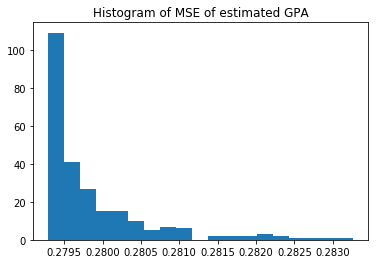

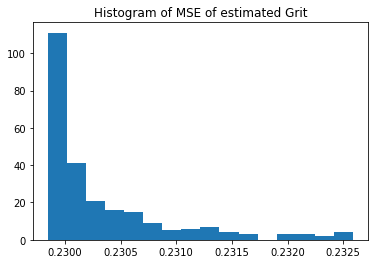

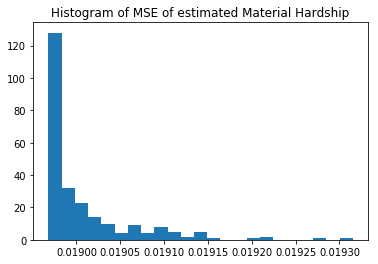

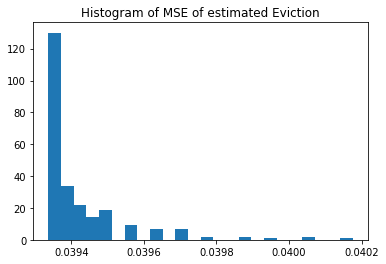

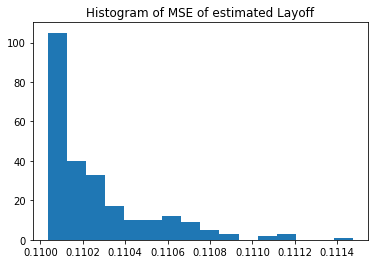

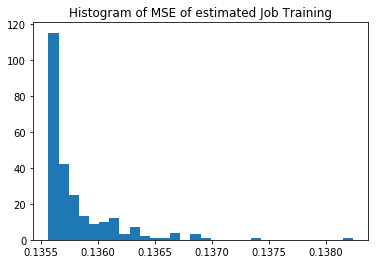


Avg of MSEs: [0.27985830989863303, 0.23032711079443635, 0.019006963324176597, 0.039421028956152855, 0.11026021779915063, 0.13579933945874589]
Std Dev of MSEs: [0.00075363422059317035, 0.00061167209895220565, 5.6374872265949851e-05, 0.00013036991555151923, 0.00026334309372425533, 0.00034005052128044741]


In [102]:
llreg = linear_model.LassoLars()

bootstrapOrdinary(ff_train_b1,ff_train_outcomes_b1,250,500,llreg)

CV bootstrap with k = 50 / n = 500 / folds = 5
..........................................................................................................................................................................................................................................................

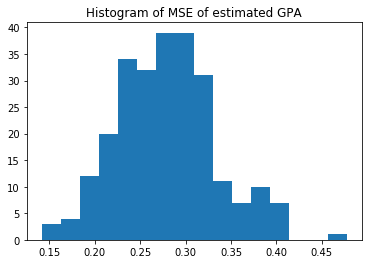

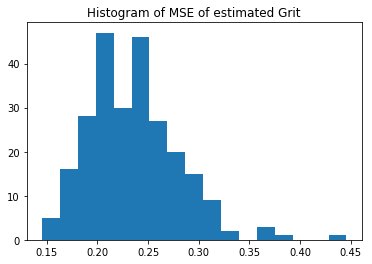

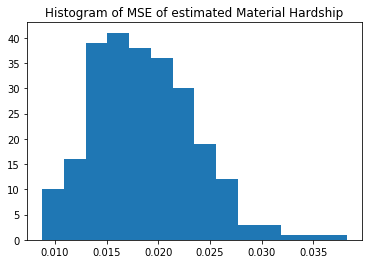

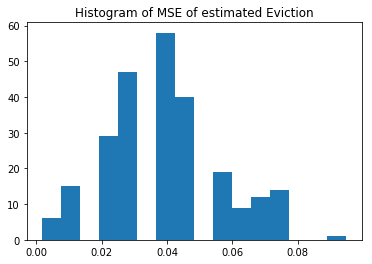

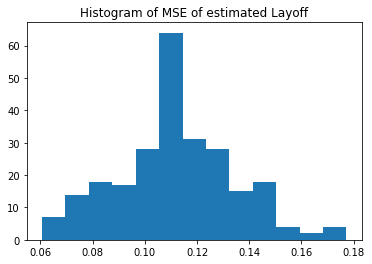

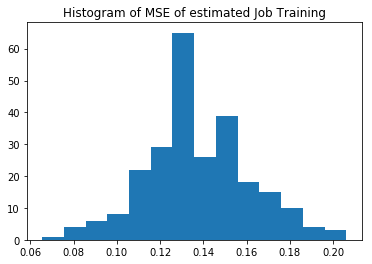


Avg of MSEs: [0.27943931562499996, 0.23556713750000002, 0.018728067355371917, 0.039590599999999997, 0.11182989999999998, 0.13767499999999999]
Std Dev of MSEs: [0.054315827251054973, 0.044050079106312659, 0.0049868658139620081, 0.017928915378237445, 0.02258951610515374, 0.024145564848953117]


In [104]:
llreg = linear_model.LassoLars()

bootstrapCV(ff_train_b1,ff_train_outcomes_b1,50,500,5,llreg)

Leave one out bootstrap with k = 250 / n = 500
..........................................................................................................................................................................................................................................................

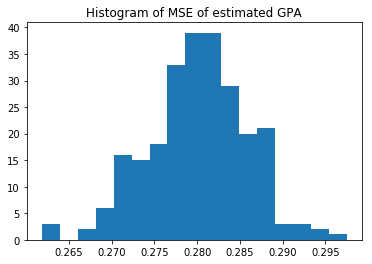

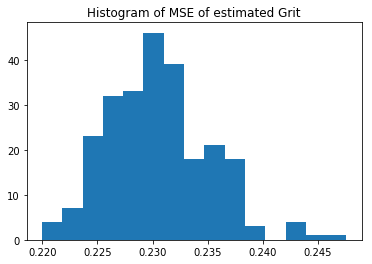

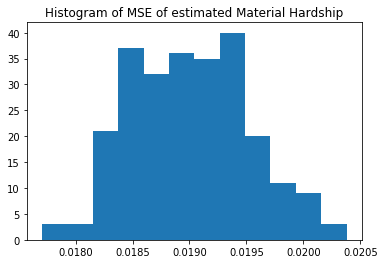

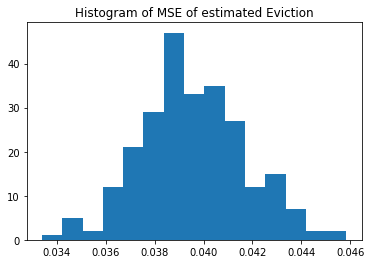

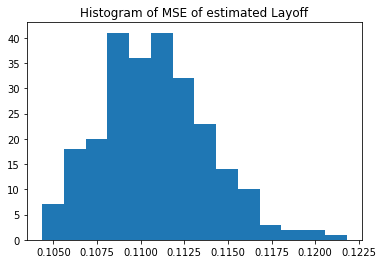

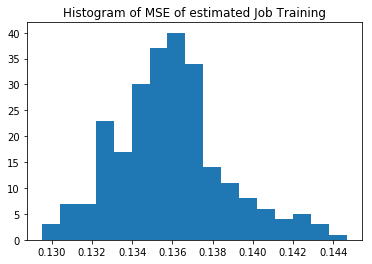


Avg of MSEs: [0.2801038433188851, 0.23054209973768616, 0.019003916348956842, 0.039570758009213773, 0.11080670064792283, 0.13585470434781735]
Std Dev of MSEs: [0.0058009810431667507, 0.0045980621920316336, 0.00051921065783334453, 0.0021146697590801091, 0.0030899398061783019, 0.0027080983364861284]


In [110]:
llreg = linear_model.LassoLars()

bootstrapLOO(ff_train_b1,ff_train_outcomes_b1,250,500,llreg)